# <!-- TITLE --> Projet 6 : notebook 3
<!-- AUTHOR : Anthony DAVID -->

In [3]:
import os, time, sys, pathlib, json, glob
import math, random
import datetime
import itertools
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import h5py

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import TensorBoard

import sklearn.metrics

from skimage.morphology import disk
from skimage.util import img_as_ubyte
from skimage.filters import rank
from skimage import io, color, exposure, transform
from IPython.display import display,Image,Markdown,HTML

In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
# 0 = all messages are logged (default behavior)
# 1 = INFO messages are not printed
# 2 = INFO and WARNING messages are not printed
# 3 = INFO, WARNING, and ERROR messages are not printed

# 4 - Data augmentation

## 4.1 - Parameters, Model, and Callbacks  

### 4.1.1 - Parameters

In [5]:
import os

# Dossier de destination contenant les images copiées
destination_dir = './selected_data/images/'

# Vérifier si le dossier de destination existe et récupérer les noms des classes
if os.path.exists(destination_dir):
    class_names = [breed_dir for breed_dir in os.listdir(destination_dir) if os.path.isdir(os.path.join(destination_dir, breed_dir))]
else:
    class_names = []

# Nombre de classes
num_classes = len(class_names)

# Affichage
print("Class names:", class_names)
print("Number of classes:", num_classes)

Class names: ['Rottweiler', 'Doberman', 'Weimaraner', 'Staff', 'Malinois']
Number of classes: 5


In [6]:
enhanced_dir = './data'
dataset_name  = 'set-RGB'

In [7]:
batch_size    = 16
epochs        = 30
fit_verbosity = 1

### 4.1.2 - Model

In [8]:
def first_model_augmented(lx,ly,lz):
    model = keras.models.Sequential()

    model.add( keras.layers.RandomFlip('horizontal'))
    model.add( keras.layers.RandomRotation(0.2))
    
    model.add( keras.layers.Conv2D(32, (3,3),   activation='relu', input_shape=(lx,ly,lz)))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(64, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(128, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Conv2D(256, (3, 3), activation='relu'))
    model.add( keras.layers.MaxPooling2D((2, 2)))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Flatten()) 
    model.add( keras.layers.Dense(1152, activation='relu'))
    model.add( keras.layers.Dropout(0.2))

    model.add( keras.layers.Dense(num_classes, activation='softmax'))
    return model

### 4.1.3 - Callbacks
We prepare 2 kind callbacks :  TensorBoard and Best Model backup

In [9]:
def tag_now():
    '''
    Return a string tag for current date/time
    args:
        nothing
    return:
        current formated date/time tag as '%Y-%m-%d_%Hh%Mm%Ss'
    '''
    return datetime.datetime.now().strftime("%Y-%m-%d_%Hh%Mm%Ss")

In [10]:
run_dir = './run_augmented'
figs_dir = './figs_augmented'

os.makedirs(run_dir + '/models', mode=0o750, exist_ok=True)
os.makedirs(run_dir + '/logs', mode=0o750, exist_ok=True)
os.makedirs(figs_dir, mode=0o750, exist_ok=True)

# ---- Callback tensorboard
log_dir = run_dir + "/logs/tb_" + tag_now()
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

# ---- Callback ModelCheckpoint - Save best model
save_dir = run_dir + "/models/best-model.keras"
bestmodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0, monitor='accuracy', save_best_only=True)

# ---- Callback ModelCheckpoint - Save model each epochs
save_dir = run_dir + "/models/model-{epoch:04d}.keras"
savemodel_callback = tf.keras.callbacks.ModelCheckpoint(filepath=save_dir, verbose=0)

path=os.path.abspath(f'{run_dir}/logs')
print(f'To run tensorboard :\ntensorboard --logdir {path}')

To run tensorboard :
tensorboard --logdir /Users/anthonydavid/Workspace/Openclassrooms/projet_6/run_augmented/logs


## 4.2 - Data generator

### 4.2.1 - Generate the new images

In [12]:
# a function to shuffle the dataset

def shuffle_np_dataset(*data):
    """
    Shuffle a list of dataset
    args:
        *data : datasets
    return:
        *datasets mixed
    """
    p = np.random.permutation(len(data[0]))
    out = [d[p] for d in data]
    return out[0] if len(out) == 1 else out

# a function to read the dataset

def read_dataset(enhanced_dir, dataset_name):
    '''Reads h5 dataset including train, val, and test splits
    Args:
        enhanced_dir : directory where datasets are saved
        dataset_name : dataset name, without .h5
    Returns:    x_train, y_train, x_val, y_val, x_test, y_test data'''
    # ---- Read dataset
    filename = f'{enhanced_dir}/{dataset_name}.h5'
    with h5py.File(filename, 'r') as f:
        x_train = f['x_train'][:]
        y_train = f['y_train'][:]
        x_val = f['x_val'][:]
        y_val = f['y_val'][:]
        x_test = f['x_test'][:]
        y_test = f['y_test'][:]
    print(x_train.shape, y_train.shape)
    # ---- Shuffle train data only
    x_train, y_train = shuffle_np_dataset(x_train, y_train)

    print(f'Dataset "{dataset_name}" is loaded and shuffled.')
    return x_train, y_train, x_val, y_val, x_test, y_test

In [13]:
# Read dataset
x_train, y_train, x_val, y_val, x_test, y_test = read_dataset(enhanced_dir, dataset_name)

(604, 224, 224, 3) (604,)
Dataset "set-RGB" is loaded and shuffled.


In [35]:
"""
datagen = keras.preprocessing.image.ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen = keras.preprocessing.image.ImageDataGenerator(
    # rescale=1.0/255.0,           # Rescale pixel values to [0, 1]
    rotation_range=10.,           # Random rotation up to 20 degrees
    width_shift_range=0.1,       # Random horizontal shift by 20% of the width
    height_shift_range=0.1,      # Random vertical shift by 20% of the height
    shear_range=0.2,             # Random shear transformations
    zoom_range=0.2,              # Random zoom in/out
    horizontal_flip=True,        # Random horizontal flips
    fill_mode='nearest'          # Fill mode for newly created pixels
)

datagen.fit(x_train)
"""

### Let's try another method
# In the model 'first_model_augmented' we used the following layers for data augmentation : 

# data_augmentation = tf.keras.Sequential([
#   tf.keras.layers.RandomFlip('horizontal'),
#   tf.keras.layers.RandomRotation(0.2),
# ])

# Data augmentation avec ImageDataGenerator
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Appliquez datagen à vos données d'entraînement
datagen.fit(x_train)

### 4.2.2 - Visualize the generated images

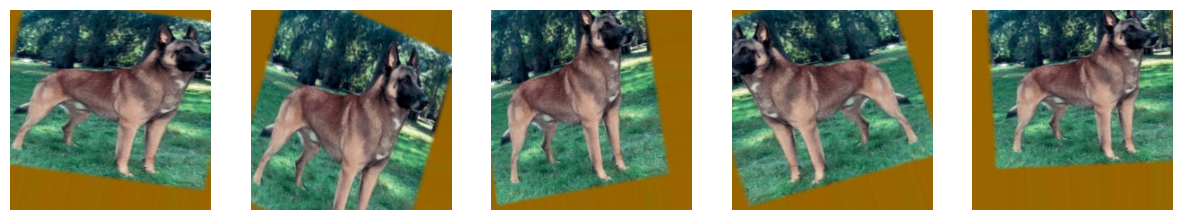

In [36]:
# """
# ---- Get a random image
#
i    = random.randint(1, len(x_train))
x, y = x_train[i], x_train[i]

# Reshape the image to fit the datagen flow
sample_image = np.expand_dims(x, axis=0)

# Generate augmented images
augmented_images = datagen.flow(sample_image, batch_size=1)

# Visualize the augmented images
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    augmented_image = augmented_images.__next__()[0]
    axes[i].imshow(augmented_image)
    axes[i].axis('off')

plt.show()
# """

# for image, _ in train_data.take(1):
#   plt.figure(figsize=(10, 10))
#   first_image = image[0]
#   for i in range(9):
#     ax = plt.subplot(3, 3, i + 1)
#     augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
#     plt.imshow(augmented_image[0] / 255)
#     plt.axis('off')

## 4.3 - Train the model
**Get my data shape :**

In [2]:
(n,lx,ly,lz) = x_train.shape
print("Images of the dataset have this folowing shape : ",(lx,ly,lz))

NameError: name 'x_train' is not defined

**Get and compile a model, with the data shape :**

In [38]:
model = first_model_augmented(lx,ly,lz)

# model.summary()

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

/Users/anthonydavid/Workspace/Openclassrooms/projet_6/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


**Train it :** 

In [39]:
# """
train_generator = datagen.flow(
    x_train,
    y_train,
    batch_size=batch_size,
    shuffle=True  # Don't shuffle the data during training
)

history = model.fit(  train_generator,
                      # steps_per_epoch = len(x_train) // batch_size,
                      batch_size=batch_size,
                      epochs=epochs,
                      verbose=1,
                      validation_data=(x_val, y_val),
                      callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )
# """

# history = model.fit(  x_train, y_train,
#                       batch_size=batch_size,
#                       epochs=epochs,
#                       verbose=fit_verbosity,
#                       validation_data=(x_val, y_val),
#                       callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback] )

model.save(f'{run_dir}/models/last-model.keras')

/Users/anthonydavid/Workspace/Openclassrooms/projet_6/.venv/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 82s 2s/step - accuracy: 0.2049 - loss: 1.7738 - val_accuracy: 0.2558 - val_loss: 1.6059
Epoch 2/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 96s 2s/step - accuracy: 0.2394 - loss: 1.6060 - val_accuracy: 0.2151 - val_loss: 1.6060
Epoch 3/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 117s 3s/step - accuracy: 0.2644 - loss: 1.5929 - val_accuracy: 0.1919 - val_loss: 1.5985
Epoch 4/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 35s 869ms/step - accuracy: 0.2619 - loss: 1.5685 - val_accuracy: 0.2965 - val_loss: 1.5792
Epoch 5/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 794ms/step - accuracy: 0.2896 - loss: 1.5468 - val_accuracy: 0.3256 - val_loss: 1.5488
Epoch 6/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 31s 829ms/step - accuracy: 0.3175 - loss: 1.5008 - val_accuracy: 0.3198 - val_loss: 1.5241
Epoch 7/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 32s 854ms/step - accuracy: 0.2950 - loss: 1.5154 - val_accuracy: 0.3256 - val_loss: 1.5105
Epoch 8/30
38/38 ━━━━━━━━━━━━━━━━━━━━ 30s 786ms/step - accuracy: 0.3560 - loss: 1.4517 - val_accuracy: 0.

**Evaluate it :**

In [40]:
max_val_accuracy = max(history.history["val_accuracy"])
print("Max validation accuracy is : {:.4f}".format(max_val_accuracy))

Max validation accuracy is : 0.3779


In [41]:
score = model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 1.3706
Test accuracy  : 0.3896


## 4.4 - History
The return of model.fit() returns us the learning history

In [42]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        if save_as=='auto':
            figname='auto'
        else:
            figname=f'{save_as}_{fig_id}'
            fig_id+=1
        plt.savefig(figs_dir+'/'+figname+'.png')
        plt.show()


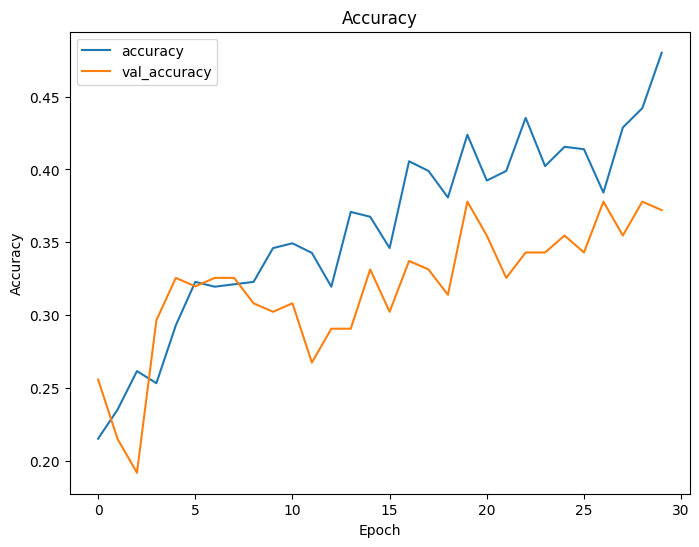

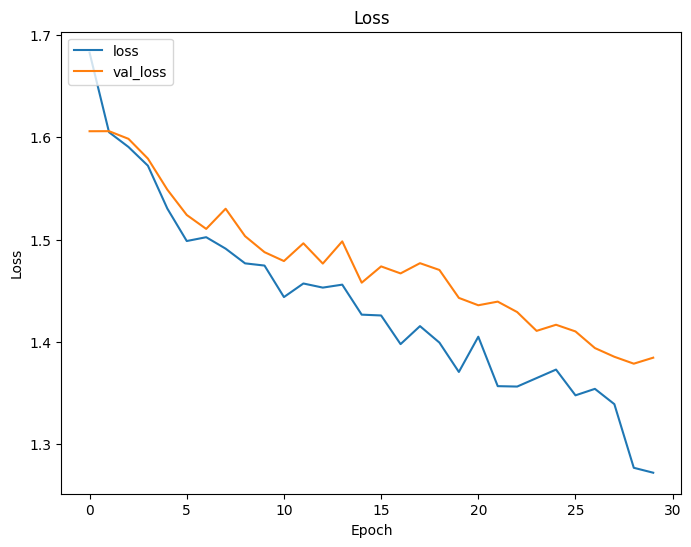

In [43]:
plot_history(history, save_as='history')

## 4.5 - Evaluate best model

### 4.5.1 - Restore best model :

In [44]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.keras')
# best_model.summary()
print("Loaded.")

Loaded.


### 4.5.2 - Evaluate it :

In [45]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 1.3706
Test accuracy  : 0.3896


**Plot confusion matrix**

In [46]:
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',
                          save_as='auto'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = sklearn.metrics.confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    target_names = [class_names[label] for label in range(len(class_names))]

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    figname=f'{save_as}'
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(figs_dir+'/'+figname+'.png')
    plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 183ms/step


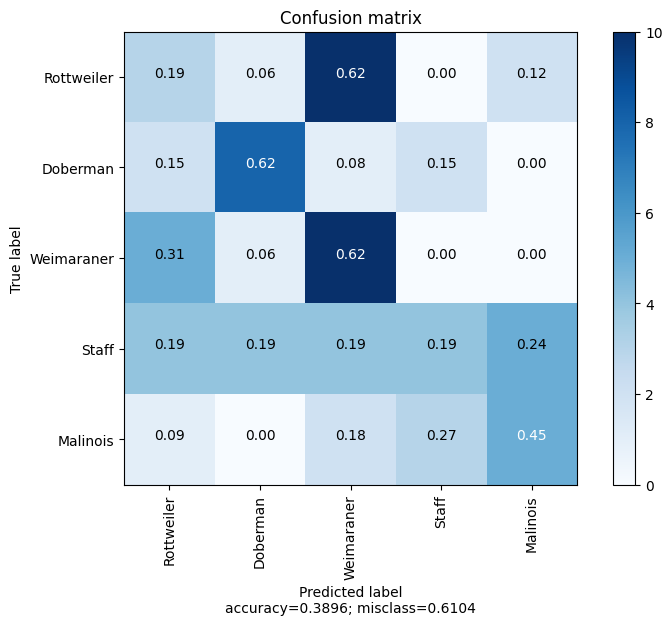

In [47]:
y_sigmoid = loaded_model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

plot_confusion_matrix(y_test, y_pred, range(num_classes), figsize=(8, 6), normalize=True, save_as='confusion-matrix')

## 4.6 - Data augmentation with dataset augmentation

### 4.2 - Data augmentation and dataset augmentation

In [14]:
# Data augmentation avec ImageDataGenerator
datagen = keras.preprocessing.image.ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Appliquer datagen pour augmenter les données et réellement agrandir le dataset
x_train_augmented = []
y_train_augmented = []

# Pour chaque image dans x_train, générer 5 nouvelles images
for i in range(len(x_train)):
    img = np.expand_dims(x_train[i], axis=0)
    augmented_iter = datagen.flow(img, batch_size=1)

    # Générer 5 augmentations par image
    for j in range(5):
        augmented_image = next(augmented_iter)[0]
        x_train_augmented.append(augmented_image)
        y_train_augmented.append(y_train[i])

# Convertir les augmentations en numpy arrays
x_train_augmented = np.array(x_train_augmented)
y_train_augmented = np.array(y_train_augmented)

# Ajouter les augmentations aux données d'entraînement originales
x_train_extended = np.concatenate([x_train, x_train_augmented])
y_train_extended = np.concatenate([y_train, y_train_augmented])

# Mélanger l'ensemble étendu
x_train_extended, y_train_extended = shuffle_np_dataset(x_train_extended, y_train_extended)

### 4.3 - Train the model

In [15]:
(n, lx, ly, lz) = x_train_extended.shape
print(f"Images of the dataset have this following shape: {(lx, ly, lz)}")

# Initialiser le modèle
model = first_model_augmented(lx, ly, lz)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Entraîner avec le dataset étendu
history = model.fit(
    x_train_extended, y_train_extended,
    batch_size=batch_size,
    epochs=epochs,
    verbose=fit_verbosity,
    validation_data=(x_val, y_val),
    callbacks=[tensorboard_callback, bestmodel_callback, savemodel_callback]
)

model.save(f'{run_dir}/models/last-model-2.keras')

Images of the dataset have this following shape: (224, 224, 3)


/Users/anthonydavid/Workspace/Openclassrooms/projet_6/.venv/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 133s 565ms/step - accuracy: 0.2297 - loss: 1.6498 - val_accuracy: 0.2849 - val_loss: 1.5716
Epoch 2/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 136s 600ms/step - accuracy: 0.3268 - loss: 1.4950 - val_accuracy: 0.3256 - val_loss: 1.5101
Epoch 3/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 107s 473ms/step - accuracy: 0.3576 - loss: 1.4401 - val_accuracy: 0.3256 - val_loss: 1.5035
Epoch 4/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 107s 472ms/step - accuracy: 0.4006 - loss: 1.3852 - val_accuracy: 0.3256 - val_loss: 1.4723
Epoch 5/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 103s 455ms/step - accuracy: 0.4358 - loss: 1.3282 - val_accuracy: 0.3837 - val_loss: 1.4073
Epoch 6/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 109s 480ms/step - accuracy: 0.4520 - loss: 1.2723 - val_accuracy: 0.3488 - val_loss: 1.3920
Epoch 7/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 109s 483ms/step - accuracy: 0.4993 - loss: 1.1886 - val_accuracy: 0.4360 - val_loss: 1.3287
Epoch 8/30
227/227 ━━━━━━━━━━━━━━━━━━━━ 117s 516ms/step - accuracy: 0.5265 -

### 4.4 - Evaluate

In [16]:
max_val_accuracy = max(history.history["val_accuracy"])
print(f"Max validation accuracy: {max_val_accuracy:.4f}")
score = model.evaluate(x_test, y_test, verbose=0)
print(f'Test loss: {score[0]:.4f}')
print(f'Test accuracy: {score[1]:.4f}')

Max validation accuracy: 0.5988
Test loss: 1.9833
Test accuracy: 0.5584


### 4.4 - History
The return of model.fit() returns us the learning history

In [17]:
def plot_history(history, figsize=(8,6), 
                 plot={"Accuracy":['accuracy','val_accuracy'], 'Loss':['loss', 'val_loss']},
                 save_as='auto'):
    """
    Show history
    args:
        history: history
        figsize: fig size
        plot: list of data to plot : {<title>:[<metrics>,...], ...}
    """
    fig_id=0
    for title,curves in plot.items():
        plt.figure(figsize=figsize)
        plt.title(title)
        plt.ylabel(title)
        plt.xlabel('Epoch')
        for c in curves:
            plt.plot(history.history[c])
        plt.legend(curves, loc='upper left')
        if save_as=='auto':
            figname='auto'
        else:
            figname=f'{save_as}_{fig_id}'
            fig_id+=1
        plt.savefig(figs_dir+'/'+figname+'.png')
        plt.show()


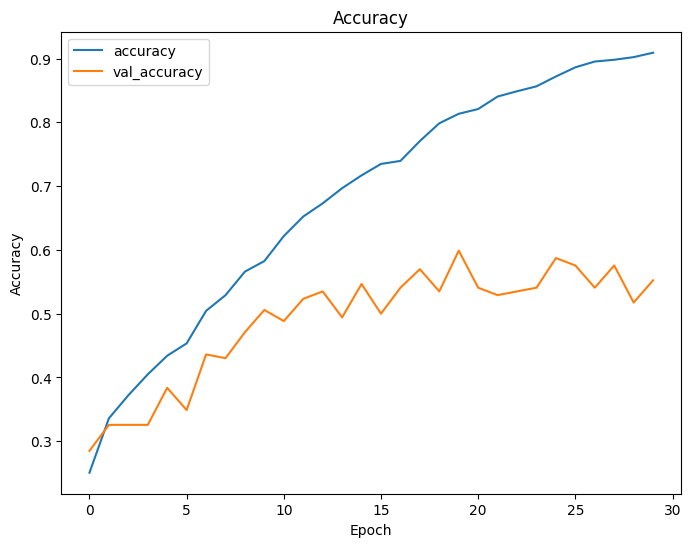

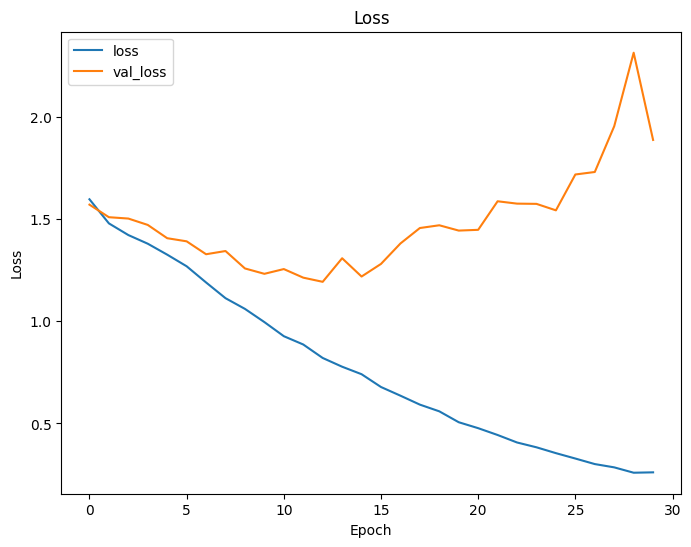

In [18]:
plot_history(history, save_as='history')

### 4.5 - Evaluate best model

#### 4.5.1 - Restore best model :

In [19]:
loaded_model = tf.keras.models.load_model(f'{run_dir}/models/best-model.keras')
# best_model.summary()
print("Loaded.")

Loaded.


#### 4.5.2 - Evaluate it :

In [20]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)

print('Test loss      : {:5.4f}'.format(score[0]))
print('Test accuracy  : {:5.4f}'.format(score[1]))

Test loss      : 1.9833
Test accuracy  : 0.5584


**Plot confusion matrix**

In [21]:
def plot_confusion_matrix(y_true,y_pred,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True,
                          figsize=(10, 8),
                          digit_format='{:0.2f}',
                          save_as='auto'):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    cm = sklearn.metrics.confusion_matrix( y_true,y_pred, normalize=None, labels=target_names)
    
    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=figsize)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    target_names = [class_names[label] for label in range(len(class_names))]

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, digit_format.format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
    figname=f'{save_as}'
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.savefig(figs_dir+'/'+figname+'.png')
    plt.show()


3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


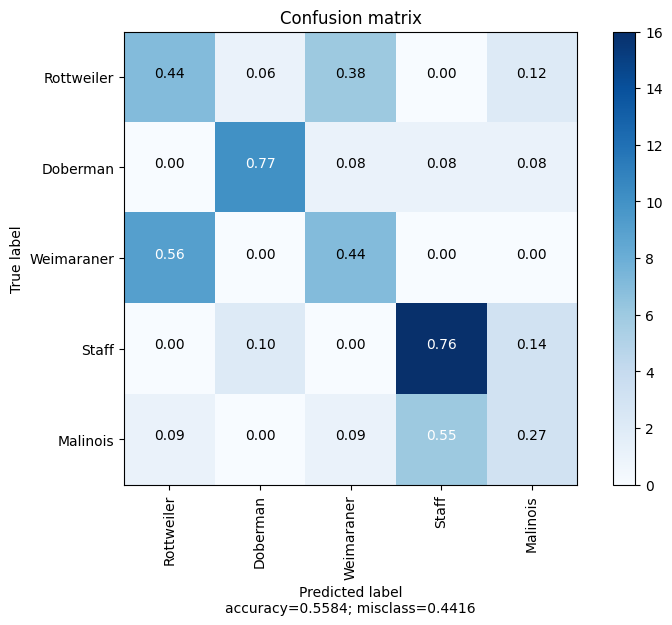

In [ ]:
y_sigmoid = loaded_model.predict(x_test)
y_pred    = np.argmax(y_sigmoid, axis=-1)

plot_confusion_matrix(y_test, y_pred, range(num_classes), figsize=(8, 6), normalize=True, save_as='confusion-matrix')